In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt

torch.set_default_dtype(torch.float64)

from torch.utils.tensorboard import SummaryWriter

import tqdm

In [2]:
device = torch.device("cuda")

In [3]:
data1 = np.load("mu_0.9.npy")
data2 = np.load("mu_0.95.npy")
data3 = np.load("mu_1.05.npy")
data4 = np.load("mu_1.1.npy")

dt = 2 / 1500

X = np.concatenate([data1, data2, data3, data4], axis=0)

x_ref = np.mean(X, axis=0)

(S, N) = X.shape

X_test = np.load("mu_1.0.npy")

In [4]:
# number of basis
n = 20
nx = 60
ny = 60

D, V = np.linalg.eigh(np.matmul((X - x_ref).T, X - x_ref))
idx = D.argsort()[::-1]
D = D[idx]
V = V[:, idx]
basis = V[:, :n]

X_approx = np.matmul(np.matmul(X_test - x_ref, basis), basis.T) + x_ref
error = np.sqrt(np.sum((X_approx - X_test) ** 2)) / np.sqrt(np.sum(X_test**2))

error

0.012485608034504674

In [5]:
def u_hat_and_u_hat_dot(basis, u, u_ref, dt):
    u_hat = np.matmul(u - u_ref, basis)
    u_hat_dot = (u_hat[1:] - u_hat[:-1]) / dt
    u_hat = u_hat[1:]
    return u_hat, u_hat_dot

In [6]:
data1_hat, data1_hat_dot = u_hat_and_u_hat_dot(basis, data1, x_ref, dt)
data2_hat, data2_hat_dot = u_hat_and_u_hat_dot(basis, data2, x_ref, dt)
data3_hat, data3_hat_dot = u_hat_and_u_hat_dot(basis, data3, x_ref, dt)
data4_hat, data4_hat_dot = u_hat_and_u_hat_dot(basis, data4, x_ref, dt)

In [7]:
X_hat = np.concatenate([data1_hat, data2_hat, data3_hat, data4_hat])
X_hat_dot = np.concatenate([data1_hat_dot, data2_hat_dot, data3_hat_dot, data4_hat_dot])

X_hat_test, X_hat_dot_test = u_hat_and_u_hat_dot(basis, X_test, x_ref, dt)

In [8]:
X_hat = torch.tensor(X_hat).to(device)
X_hat_dot = torch.tensor(X_hat_dot).to(device)
X_hat_test = torch.tensor(X_hat_test).to(device)
X_hat_dot_test = torch.tensor(X_hat_dot_test).to(device)

basis = torch.tensor(basis).to(device)
x_ref = torch.tensor(x_ref).to(device)
X_test = torch.tensor(X_test).to(device)

In [9]:
class OP(torch.nn.Module):
    def __init__(self, n, M):
        super(OP, self).__init__()

        ls = []
        in_dim = n
        for dim in M:
            ls.append(torch.nn.Linear(in_dim, dim))
            in_dim = dim
        self.ls = torch.nn.ModuleList(ls)

        # self.residual = torch.nn.Linear(n, n)

    def forward(self, x):
        # residual = self.residual(x)
        for i in range(len(self.ls) - 1):
            x = self.ls[i](x)
            x = x * torch.sigmoid(x)
        x = self.ls[-1](x)
        # x = x + residual
        return x


In [10]:
lr = 1e-3
epochs = 10000
B = 240
lr_red_factor = 0.1
patience = 10
l1_reg = 0

# op = OP(n, [500, 1000, 500, n]).to(device)
op = OP(n, [600, 1000, 1200, 1000, 600, n]).to(device)
op = torch.load('models/lsrom_ml_operator.pth')

In [11]:
with torch.no_grad():
    approximates = op(X_hat_test)
    l_test = torch.sum((X_hat_dot_test - approximates) ** 2)

torch.sqrt(l_test) / torch.sqrt(torch.sum(X_hat_dot_test**2))

tensor(0.0014, device='cuda:0')

In [12]:
# data = torch.utils.data.TensorDataset(X_hat, X_hat_dot)
# dataloader = torch.utils.data.DataLoader(data, batch_size=B, shuffle=True)

# optimizer = torch.optim.Adam(op.parameters(), lr=lr, weight_decay=l1_reg)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, "min", factor=lr_red_factor, patience=patience
# )

# best_loss = 1000
# writer = SummaryWriter()
# for epoch in range(epochs):
#     for x, x_dot in tqdm.tqdm(dataloader):
#         optimizer.zero_grad()
#         loss = torch.sqrt(torch.sum((op(x) - x_dot) ** 2))
#         loss.backward()
#         # print(op.l1.weight.grad)
#         optimizer.step()

#     with torch.no_grad():
#         approximates = op(X_hat)
#         l_train = torch.sum((X_hat_dot - approximates) ** 2)

#         approximates = op(X_hat_test)
#         l_test = torch.sum((X_hat_dot_test - approximates) ** 2)

#     if (l_train < best_loss):
#         best_loss = l_train
#         torch.save(op, 'models/lsrom_ml_operator.pth')
        

#     scheduler.step(l_train)

#     writer.add_scalar("loss/train", torch.sqrt(l_train) / torch.sqrt(torch.sum(X_hat_dot**2)), epoch)
#     writer.add_scalar("loss/mse_train", l_train / X_hat_dot.shape[1] / X_hat_dot.shape[0], epoch)
    
#     writer.add_scalar("loss/test", torch.sqrt(l_test) / torch.sqrt(torch.sum(X_hat_dot_test**2)), epoch)
#     writer.add_scalar("loss/mse_train", l_test / X_hat_dot_test.shape[1] / X_hat_dot_test.shape[0], epoch)

#     writer.add_scalar("lr", optimizer.param_groups[0]["lr"], epoch)
#     print(torch.sqrt(l_train) / torch.sqrt(torch.sum(X_hat_dot**2)))
#     print(torch.sqrt(l_test) / torch.sqrt(torch.sum(X_hat_dot_test**2)))

In [13]:
def nr_solve(f, df, x, atol=1e-10, rtol=1e-8, max_itr=50, args=None):
    r = f(x, *args)
    r0_norm = torch.linalg.norm(r)
    print("Itr = {:}, residual norm = {:.4E}".format(0, r0_norm))
    if (r0_norm < atol):
        return x
    for i in range(max_itr):
        x = torch.linalg.solve(df(x, *args), -r) + x
        r = f(x, *args)
        print("Itr = {:}, residual norm = {:.4E}".format(i + 1, torch.linalg.norm(r)))
        if (torch.linalg.norm(r) < atol or torch.linalg.norm(r) / r0_norm < rtol):
            return x
    raise Exception("solve failed")
        

In [14]:
# replace with NN: u_hat to u_hat_dot
def f(x, x_old, dt):
    x_dot = op(x)
    return x - x_old - dt * x_dot

def df(x, x_old, dt):
    x_dot = op(x)
    d_s_dot = torch.zeros(n, n).to(device)
    for i in range(n):
        inplace = torch.zeros_like(x_dot)
        inplace[i] = 1
        d_s_dot[:, i] = torch.autograd.grad(x_dot, x, inplace, retain_graph=True)[0]

    return torch.eye(n).to(device) - d_s_dot * dt

In [15]:
x_red = torch.matmul(X_test[1] - x_ref, basis)
x_red.requires_grad = True
t = 0
sol = {t : x_red}
dt = 2 / 1500
dt_min = dt / 100
while t < 2:
    print('Time = {:}, dt = {:}'.format(t + dt, dt))
    try:
        x_red = nr_solve(f, df, x_red, args=(x_red, dt))
    except:
        dt = dt / 2
        if (dt < dt_min):
            raise Exception("dt is too small")
        continue
    t = t + dt
    sol[t] = x_red

Time = 0.0013333333333333333, dt = 0.0013333333333333333
Itr = 0, residual norm = 7.1704E-02
Itr = 1, residual norm = 1.6241E-03
Itr = 2, residual norm = 3.7543E-05
Itr = 3, residual norm = 8.7101E-07
Itr = 4, residual norm = 2.0135E-08
Itr = 5, residual norm = 4.6721E-10
Time = 0.0026666666666666666, dt = 0.0013333333333333333
Itr = 0, residual norm = 7.1820E-02
Itr = 1, residual norm = 1.6420E-03
Itr = 2, residual norm = 3.8308E-05
Itr = 3, residual norm = 8.9684E-07
Itr = 4, residual norm = 2.0924E-08
Itr = 5, residual norm = 4.8992E-10
Time = 0.004, dt = 0.0013333333333333333
Itr = 0, residual norm = 7.1925E-02
Itr = 1, residual norm = 1.6578E-03
Itr = 2, residual norm = 3.8983E-05
Itr = 3, residual norm = 9.1973E-07
Itr = 4, residual norm = 2.1628E-08
Itr = 5, residual norm = 5.1033E-10
Time = 0.005333333333333333, dt = 0.0013333333333333333
Itr = 0, residual norm = 7.2022E-02
Itr = 1, residual norm = 1.6716E-03
Itr = 2, residual norm = 3.9569E-05
Itr = 3, residual norm = 9.3965E-

In [16]:
t

2.0000000000000457

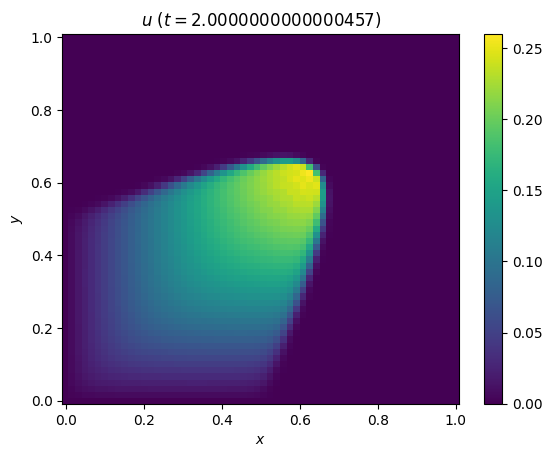

In [17]:
approximate = (torch.matmul(basis, sol[t]) + x_ref).detach().cpu().numpy()
# plot
ny = 60
nx = 60
x = np.load('paper_x.npy')
y = np.load('paper_y.npy')


fig_u = plt.figure()
ax_u = fig_u.gca()
p_u=ax_u.pcolor(x.reshape(ny,nx), y.reshape(ny,nx), (approximate).reshape(ny,nx))
cb_u=fig_u.colorbar(p_u,ax=ax_u)
ax_u.set_xlabel('$x$')
ax_u.set_ylabel('$y$')
plt.title('$u$ ($t = {:}$)'.format(t))
plt.show()

In [18]:
ref_sol = X_test[-1]
approximate = torch.matmul(basis, sol[t]) + x_ref
torch.sqrt(torch.sum(approximate - ref_sol)**2) / torch.sqrt(torch.sum(ref_sol**2))

tensor(0.0071, device='cuda:0', grad_fn=<DivBackward0>)

In [19]:
# for t, x_red in sol.items():
#     approximate = np.matmul(basis, x_red)
#     # plot
#     ny = 60
#     nx = 60
#     x = np.load('paper_x.npy')
#     y = np.load('paper_y.npy')


#     fig_u = plt.figure()
#     ax_u = fig_u.gca()
#     p_u=ax_u.pcolor(x.reshape(ny,nx), y.reshape(ny,nx), (approximate).reshape(ny,nx))
#     cb_u=fig_u.colorbar(p_u,ax=ax_u)
#     ax_u.set_xlabel('$x$')
#     ax_u.set_ylabel('$y$')
#     plt.title('$u$ ($t = {:}$)'.format(t))
#     plt.show()